# Imports 

In [281]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data setup 

In [282]:
X = np.load('data/X-data.npy')
y = np.load('data/y-data.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) #split 2-8
X_train.shape

(455, 21)

# Class definitons

In [283]:
# Abstract Class Definitions: 
class Layer():
    def __init__(self): 
        self.inputs = None  # The inputs into this layer. 
        self.outputs = None # The ouputs of this layer. 
        
    # Forward propagation method.
    def forward(self, inputs):
        pass
    
    # Backward propagation method.
    def backward(self):
        pass
    
class Activation():
    def activate():
        pass
    
    def prime():
        pass
    
class Loss():
    def calculate_loss():
        pass

In [284]:
class ReLU(Activation):
    def activate(self, x): 
        return np.maximum(x, 0.0)
    
    def derivative(self, x):
        return (x > 0) * 1  # * 1 to return a number.
    
class Sigmoid(Activation):
    def activate(self, x):
        result = np.mean(1 / (1 + np.exp(-x)))
        if math.isnan(result):
            print('here')
        return result
    
    def derivative(self, x):
        s = self.activate(x)
        return s * (1 - s)

In [285]:
class CrossEntropyLoss():
    def calculate_loss(self, y_true, y_pred):
        if y_true == 1.0:
            return np.mean(-np.log(y_pred+ 0.0001))
        else:
            return np.mean(-np.log(1-y_pred + 0.0001))
    
    def derivative(self, y_true, y_pred): 
        r = (y_pred - y_true) / y_pred * (1 - y_pred)
        return r
    
class MSELoss():
    def calculate_loss(self, y_true, y_pred):
        return np.mean(1/2 * (y_true - y_pred)**2)
    
    def derivative(self, y_true, y_pred):
        return y_pred - y_true  # (y_true - y_pred) * (-1)

In [286]:
# Dense (fully connected) Layer Class:
class Dense(Layer): 
    def __init__(self, input_size, output_size, activation_function='relu', name='unnamed'):
        self.name = name
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros((output_size, 1))
        self.outputs = None
        
        if activation_function == 'relu':
            self.activation = ReLU()
        elif activation_function == 'sigmoid':
            self.activation = Sigmoid()
        else:
            self.activation = ReLU()  # Default to ReLU activation function.
        
    def print_weights(self):
        print('Weights:\n', pd.DataFrame(self.weights))
        
    def print_biases(self):
        print('Biases:\n', pd.DataFrame(self.biases))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = self.activation.activate(np.dot(self.weights, inputs) + self.biases)
        return self.outputs
    
    def backward(self, delta_l, prev_weights, x, learning_rate):                
        delta_l = np.dot(delta_l.T, prev_weights) * self.activation.derivative(self.outputs).T
        prev_weights = self.weights
        gradient = delta_l * np.dot(x, np.ones((1, len(self.outputs))))
        self.weights -= learning_rate * gradient.T 
        return delta_l, prev_weights

In [287]:
class Network:
    def __init__(self, layers, loss_function='cross_entropy'):
        self.layers = layers
        self.output = None
        
        if loss_function == 'cross_entropy':
            self.loss = CrossEntropyLoss()
        elif loss_function == 'mse':
            self.loss = MSELoss()
        else:
            self.loss = CrossEntropyLoss()  # Default to cross entropy loss. 
    
    def train(self, X_train, y_train, number_epochs, learning_rate=0.001):
        for epoch in range(number_epochs):
            error_v = 0
            
            for x, y in zip(X_train, y_train):
                # Process the forward pass. This goes through every layer.
                x = x.reshape(21, 1)  # Create a matrix for dot product in forward()
                y_hat = self.predict(x) 
                
                # Calculate the error after the forward pass. 
                loss = self.loss.calculate_loss(y, y_hat)
                if math.isnan(loss):
                    print('y_hat', y_hat)
                    print('y', y)
                    
                error = self.loss.derivative(y, y_hat)
                error_v += loss  # Add to the error visualisation.
                
                l0 = self.layers[0]
                l1 = self.layers[-1]
                
                # The output layer error.
                delta_l = np.multiply(error, l1.activation.derivative(l1.outputs))
                prev_weights = l1.weights
                l1.weights -= learning_rate * (l1.inputs.T * delta_l)
                
                for layer in reversed(self.layers[:-1]):
                    delta_l, prev_weights = layer.backward(delta_l, prev_weights, x, learning_rate)
            
            error_v /= len(X)
            error_viz.append(error_v)
                
                   
    def predict(self, x):
        outputs = x
        for layer in self.layers:
            outputs = layer.forward(outputs)
        self.output = outputs
        return outputs
            

For backpropagation, the formula for the very last layer is: 
![last-layer-backprop](https://miro.medium.com/max/828/1*zRDMl-GxVO7qENH5dNrZ-g.png)

In [288]:
def print_layer_outputs(network):
    for layer in network.layers:
        print(layer.name, layer.outputs.shape, ':\n', layer.outputs)

# Training

#### Constants 

In [311]:
np.random.seed(20)  # To keep results consistent.
error_viz = []
number_inputs = X.shape[1]
epochs = 100

#### Architecture

In [312]:
layers = [
    Dense(number_inputs, 5, activation_function='relu', name='Layer '),
    Dense(5, 1, activation_function='sigmoid', name='Layer 2')
]

#### Training loop

In [313]:
network = Network(layers, loss_function='cross_entropy')
network.train(X_train, y_train, number_epochs=epochs, learning_rate = 0.001)
#print_layer_outputs(network)

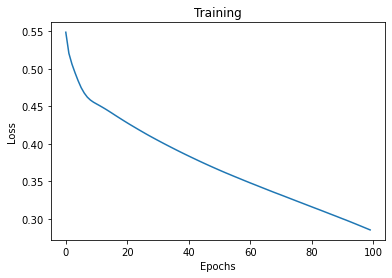

In [314]:
plt.plot(error_viz)
plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Evaluation

In [315]:
def eval(network, X, y_true):
    pred = []
    for xi in X:
        pred.append(network.predict(xi.reshape(21, 1)))
    y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred))
    return accuracy_score(y_true, y_pred)

In [316]:
print(f"Training accuracy: {eval(network, X_train, y_train)*100}")
print(f"Test accuracy: {eval(network, X_test, y_test)*100}")


Training accuracy: 85.49450549450549
Test accuracy: 84.21052631578947
